# Predictive Analytics Technical Project

Building a Predictive Medical Diagnostic System Using Advanced Machine Learning Models

## 1. Setting up the Environment

This section imports the required libraries. It also ensures the environment is ready for data analysis and modeling.

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Utilities
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Specific Libraries for Models
from xgboost import XGBClassifier
import lightgbm as lgb

# Visualization Tools
from matplotlib.ticker import MaxNLocator

# Tabular Output
from tabulate import tabulate

# File Handling and Miscellaneous
import gdown
import time


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 2. Data Sourcing and Ingesting (Data Loading)
Loading and exploring the provided dataset containing 132 symptoms and 42 possible diseases.

In my project, I’m using the gdown library to download the 'DiseaseTesting.csv' and 'DiseaseTraining.csv' files directly from Google Drive using their unique file IDs. This approach saves me time and makes the process smoother since I don’t have to manually download the files every time. Once the files are downloaded, I load them into pandas DataFrames using pd.read_csv()

In [2]:
# Downloading files from Google Drive

# File IDs for datasets on Google Drive
DiseaseTesting_id = "1uhpMiyMNMB-Y6a8sPgki-LG6LRdQR35U"
DiseaseTraining_id = "17JYYzakGyxztFhsh87SX9CU5RKJNxzt9"

# Downloading the training and testing files
DiseaseTesting_url = f"https://drive.google.com/uc?id={DiseaseTesting_id}"
gdown.download(DiseaseTesting_url, "DiseaseTesting.csv", quiet=False)

DiseaseTraining_url = f"https://drive.google.com/uc?id={DiseaseTraining_id}"
gdown.download(DiseaseTraining_url, "DiseaseTraining.csv", quiet=False)

# Loading the datasets into DataFrames
train_data = pd.read_csv("DiseaseTraining.csv")
test_data = pd.read_csv("DiseaseTesting.csv")

# Checking the first few rows of the training and testing data
train_data_head = train_data.head().values.tolist()

# Displaying the first few rows of the training data
print("\nTraining Data - First Few Rows:")
print(tabulate(train_data_head, headers=train_data.columns, tablefmt="fancy_grid"))

# Repeating the same for testing data
test_data_head = test_data.head().values.tolist()

# Displaying the first few rows of the testing data
print("\nTesting Data - First Few Rows:")
print(tabulate(test_data_head, headers=test_data.columns, tablefmt="fancy_grid"))


Downloading...
From: https://drive.google.com/uc?id=1uhpMiyMNMB-Y6a8sPgki-LG6LRdQR35U
To: /content/DiseaseTesting.csv
100%|██████████| 13.8k/13.8k [00:00<00:00, 22.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=17JYYzakGyxztFhsh87SX9CU5RKJNxzt9
To: /content/DiseaseTraining.csv
100%|██████████| 1.38M/1.38M [00:00<00:00, 103MB/s]


Training Data - First Few Rows:
╒═══════════╤═════════════╤════════════════════════╤═══════════════════════╤═════════════╤══════════╤══════════════╤════════════════╤═══════════╤════════════════════╤══════════════════╤════════════╤═══════════════════════╤═══════════════════════╤═══════════╤═══════════════╤═══════════╤════════════════════════╤═══════════════╤═══════════════╤════════════════╤════════════╤═════════════════════╤═════════════════════════╤═════════╤══════════════╤═══════════════╤══════════════════╤════════════╤═══════════════╤═══════════════╤════════════╤══════════════════╤══════════════╤══════════╤════════════════════╤════════════════════════╤═════════════╤════════════════╤══════════════════╤═════════════╤══════════════╤════════════════╤═════════════════════╤═══════════════════════╤══════════════════╤═══════════════════════╤═══════════════════════╤═══════════╤════════════════════════════════╤══════════╤═════════════════════╤═══════════════════╤══════════════════╤═══════════

## 3. Exploratory Data Analysis (EDA)
For our medical diagnostic dataset, we need to break it down into several tasks as outlined:

*   Summary Statistics
*   Data Cleaning
*   Class Imbalance Analysis
*   Correlation Analysis









In [3]:
# Shape of the datasets
shape_data = [["Training Data", train_data.shape[0], train_data.shape[1]],
              ["Testing Data", test_data.shape[0], test_data.shape[1]]]
print("\nDataset Shapes:")
print(tabulate(shape_data, headers=["Dataset", "Rows", "Columns"], tablefmt="fancy_grid"))

# Displaying the column names
columns_data = [["Column Names"] + list(train_data.columns)]
print("\nTraining Data Columns:")
print(tabulate(columns_data, tablefmt="fancy_grid"))



Dataset Shapes:
╒═══════════════╤════════╤═══════════╕
│ Dataset       │   Rows │   Columns │
╞═══════════════╪════════╪═══════════╡
│ Training Data │   4920 │       134 │
├───────────────┼────────┼───────────┤
│ Testing Data  │     42 │       133 │
╘═══════════════╧════════╧═══════════╛

Training Data Columns:
╒══════════════╤═════════╤═══════════╤══════════════════════╤═════════════════════╤═══════════╤════════╤════════════╤══════════════╤═════════╤══════════════════╤════════════════╤══════════╤═════════════════════╤═════════════════════╤═════════╤═════════════╤═════════╤══════════════════════╤═════════════╤═════════════╤══════════════╤══════════╤═══════════════════╤═══════════════════════╤═══════╤════════════╤═════════════╤════════════════╤══════════╤═════════════╤═════════════╤══════════╤════════════════╤════════════╤════════╤══════════════════╤══════════════════════╤═══════════╤══════════════╤════════════════╤═══════════╤════════════╤══════════════╤═══════════════════╤═══════════


Now, I am going to check for any missing values in the "train" and "test" data.

In [4]:
# Checking for missing values in training data

missing_values_train = train_data.isnull().sum()
missing_train_df = pd.DataFrame({"Column": missing_values_train.index, "Missing Values": missing_values_train.values})
print("\nMissing values in training data:")
print(tabulate(missing_train_df[missing_train_df["Missing Values"] > 0], headers="keys", tablefmt="fancy_grid"))

# Checking for missing values in testing data

missing_values_test = test_data.isnull().sum()
missing_test_df = pd.DataFrame({"Column": missing_values_test.index, "Missing Values": missing_values_test.values})
print("\nMissing values in testing data:")
print(tabulate(missing_test_df[missing_test_df["Missing Values"] > 0], headers="keys", tablefmt="fancy_grid"))



Missing values in training data:
╒═════╤══════════════╤══════════════════╕
│     │ Column       │   Missing Values │
╞═════╪══════════════╪══════════════════╡
│ 133 │ Unnamed: 133 │             4920 │
╘═════╧══════════════╧══════════════════╛

Missing values in testing data:
╒══════════╤══════════════════╕
│ Column   │ Missing Values   │
╞══════════╪══════════════════╡
╘══════════╧══════════════════╛


We can see that the columns "itching", "skin_rash", "nodal_skin_eruptions", "continuous_sneezing", etc., do not have any missing values (i.e., they all show 0 under missing values).

However, there's one column named "Unnamed: 133" with 4920 missing values. This suggests that it might be an empty or irrelevant column, which should be removed.

In [5]:
# Dropping unnecessary columns
columns_to_drop = ["Unnamed: 133"]
train_data.drop(columns=columns_to_drop, inplace=True)

# Verifying no missing values remain
missing_values = train_data.isnull().sum().sum()
print("\nMissing Values after Cleaning:")
print(tabulate([["Missing Values", missing_values]], headers=["Description", "Count"], tablefmt="fancy_grid"))
# Filter numeric columns from the training data
numeric_data = train_data.select_dtypes(include=[np.number])

# Custom Statistical Summary for Training Data
summary = pd.DataFrame({
    "Mean": numeric_data.mean(),
    "Median": numeric_data.median(),
    "Variance": numeric_data.var(),
    "Standard Deviation": numeric_data.std(),
    "Minimum": numeric_data.min(),
    "Maximum": numeric_data.max(),
    "Range": numeric_data.max() - numeric_data.min()

}).transpose()

# Renaming the columns for better readability
summary.columns = numeric_data.columns

# Displaying the summary
print("\nStatistical Summary of Training Data:")
print(tabulate(summary, headers="keys", tablefmt="fancy_grid"))



Missing Values after Cleaning:
╒════════════════╤═════════╕
│ Description    │   Count │
╞════════════════╪═════════╡
│ Missing Values │       0 │
╘════════════════╧═════════╛

Statistical Summary of Training Data:
╒════════════════════╤═══════════╤═════════════╤════════════════════════╤═══════════════════════╤═════════════╤══════════╤══════════════╤════════════════╤═══════════╤════════════════════╤══════════════════╤════════════╤═══════════════════════╤═══════════════════════╤═══════════╤═══════════════╤═══════════╤════════════════════════╤═══════════════╤═══════════════╤════════════════╤════════════╤═════════════════════╤═════════════════════════╤══════════╤══════════════╤═══════════════╤══════════════════╤════════════╤═══════════════╤═══════════════╤════════════╤══════════════════╤══════════════╤══════════╤════════════════════╤════════════════════════╤═════════════╤════════════════╤══════════════════╤═════════════╤══════════════╤════════════════╤═════════════════════╤══════════════

Now, Our data is clean and there is no missing values and unnamed colums.

### Class Imbalance Analysis

We'll check if the target variable prognosis is imbalanced. This can severely affect the accuracy and generalization of the model, especially for underrepresented diseases.


Class Distribution in Training Data:
prognosis
Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B 

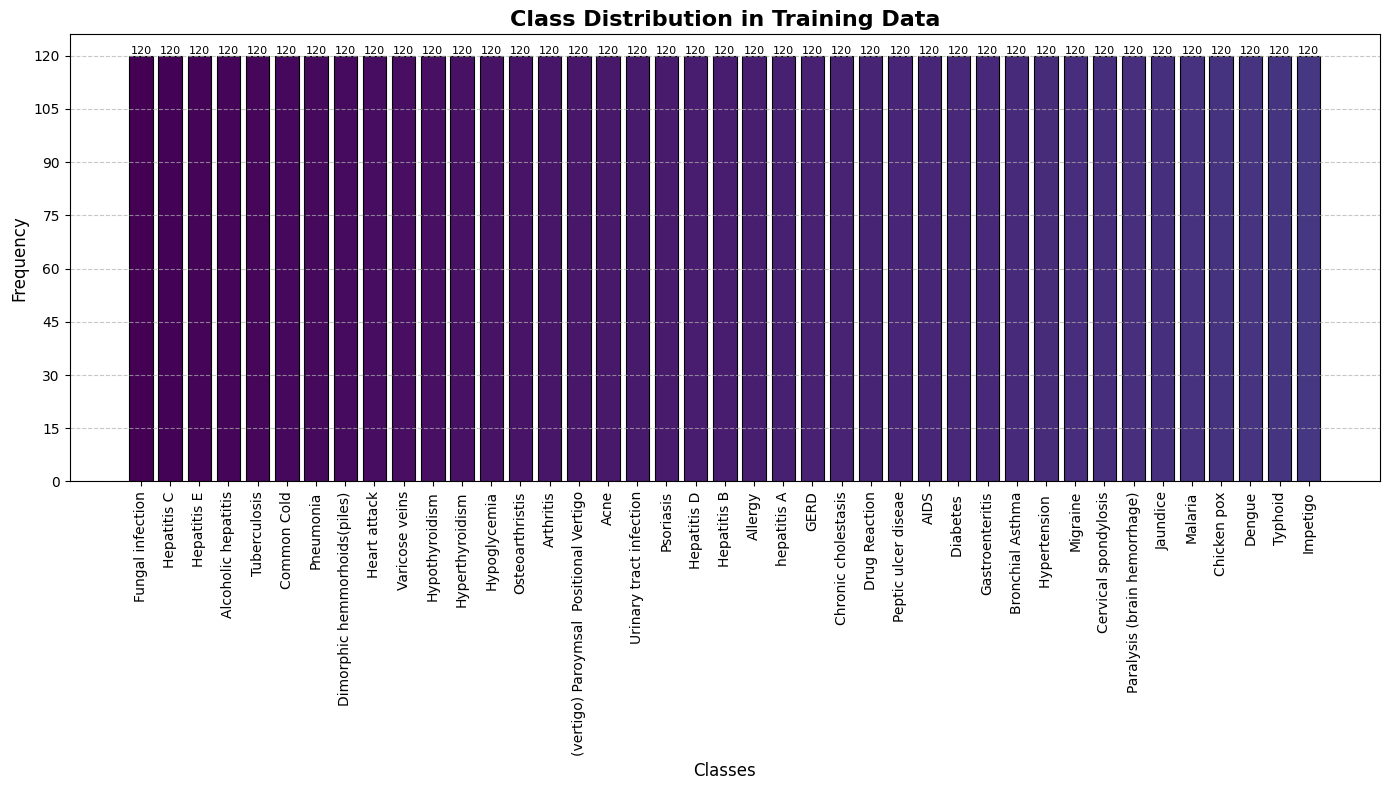

In [6]:
# Analysing the class distribution in the training data

class_counts = train_data['prognosis'].value_counts()
print("\nClass Distribution in Training Data:")
print(class_counts)

# Ploting the class distribution for visualization

plt.figure(figsize=(14, 8))

# Using a gradient-like effect
colors = plt.cm.viridis(range(len(class_counts)))
bars = plt.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=0.8)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=8)

# Customizing Visuals
plt.title("Class Distribution in Training Data", fontsize=16, weight='bold')
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure y-axis ticks are integers
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis
plt.tight_layout()

plt.show()


The class distribution in the dataset is completely balanced, with each disease class having exactly 120 instances. This indicates that oversampling or undersampling techniques to address class imbalance are unnecessary for this dataset.

### Correlation Analysis
Checking for any correlations between features using heat

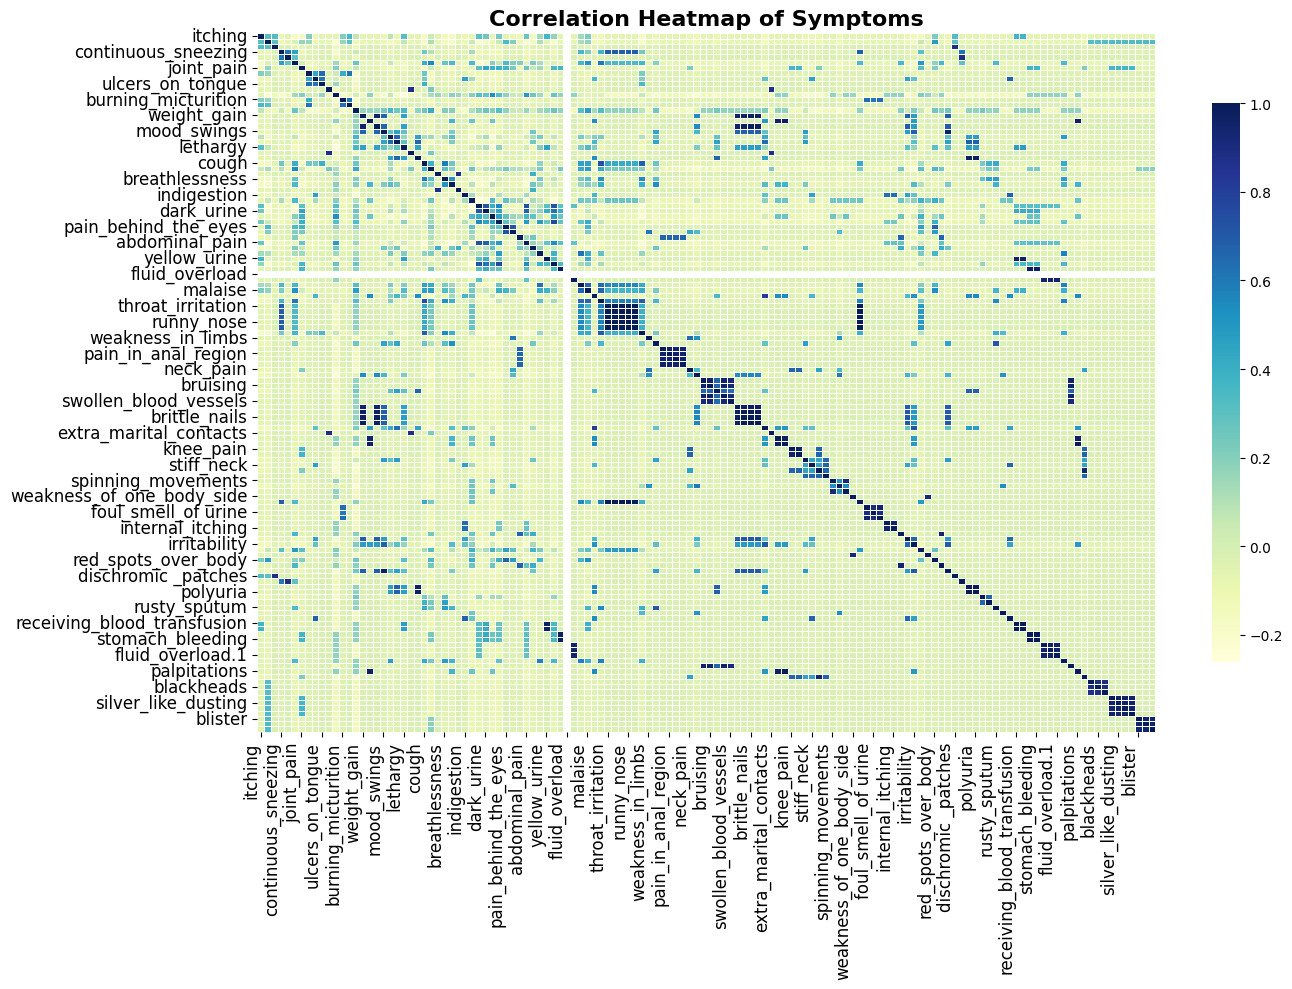

In [7]:
# Calculating any correlations for features
target_column = "prognosis"
correlation_matrix = train_data.drop(columns=[target_column]).corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=False, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Symptoms", fontsize=16, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


The heatmap shows how symptoms (features) are related. Strong correlations (in dark blue) mean symptoms often appear together, while weak correlations (near 0) mean they don't have a strong link. Some features are highly correlated, which could lead to redundancy.

Since I am using a tree-based models XGBoost, it's not a big deal. It can handle correlations well by splitting the data into ,decision rules, so we don’t need to worry about removing correlated features. However, for the other models like SVM and Logistic Regression, we need to handle this correlations.

## 4. Feature Engineering

In this section, we encode the target variable and ensure the dataset is structured for machine learning models.

### Label Encoding
Encoding is always required if your target variable contains text or categorical data.We need to encode the target variable if it is not already numeric.
(In our dataset, prognosis appears to be categorical, so encoding is necessary.)

In [8]:
# Checking if the target column exists
target_column = "prognosis"
if target_column in train_data.columns and target_column in test_data.columns:

    # Initializing LabelEncoder
    label_encoder = LabelEncoder()
    train_data[target_column] = label_encoder.fit_transform(train_data[target_column])
    test_data[target_column] = label_encoder.transform(test_data[target_column])

    # Getting unique labels in the training data
    unique_labels = train_data[target_column].nunique()

    # output
    print("\nLabel Encoding Completed for 'prognosis'.\n")

    # Create a table-like output
    summary_data = [
        ["Target Column", target_column],
        ["Unique Labels in Training Data", unique_labels]
    ]

    # Printing the summary in a table format
    print(tabulate(summary_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))



Label Encoding Completed for 'prognosis'.

╒════════════════════════════════╤═══════════╕
│ Metric                         │ Value     │
╞════════════════════════════════╪═══════════╡
│ Target Column                  │ prognosis │
├────────────────────────────────┼───────────┤
│ Unique Labels in Training Data │ 41        │
╘════════════════════════════════╧═══════════╛


 prognosis column has been successfully encoded in both the training and testing datasets. The output shows that the symptoms (features) are now represented by binary values (1 or 0), and the prognosis column, which previously had disease names, now contains encoded integer values.

### Feature and Target Separation

Split data into training and validation sets

In [9]:
# Doing feature and target separation

X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

# Displaying the results
data_shapes = [
    ["Training Features Shape", X_train.shape],
    ["Training Target Shape", y_train.shape],
    ["Testing Features Shape", X_test.shape],
    ["Testing Target Shape", y_test.shape]
]

print("\nFeature and Target Separation Completed:")
print(tabulate(data_shapes, headers=["Description", "Shape"], tablefmt="fancy_grid"))

print("\nData is cleaned, encoded, and ready for modeling.")



Feature and Target Separation Completed:
╒═════════════════════════╤═════════════╕
│ Description             │ Shape       │
╞═════════════════════════╪═════════════╡
│ Training Features Shape │ (4920, 132) │
├─────────────────────────┼─────────────┤
│ Training Target Shape   │ (4920,)     │
├─────────────────────────┼─────────────┤
│ Testing Features Shape  │ (42, 132)   │
├─────────────────────────┼─────────────┤
│ Testing Target Shape    │ (42,)       │
╘═════════════════════════╧═════════════╛

Data is cleaned, encoded, and ready for modeling.


## 5. Model Building
This section develops predictive models, tunes hyperparameters using RandomizedSearchCV, and evaluates model performance using various metrics

### Train Models Using Hyperparameter Tuning
Instead of using GridSearchCV, I opted for RandomizedSearchCV for hyperparameter tuning because it’s more time-efficient. While Grid Search tests every possible combination of hyperparameters, Random Search randomly samples from the hyperparameter space, which allows it to find optimal configurations faster, especially when there are many hyperparameters to tune. This way, I achieved good performance while reducing computational time.

#### XGBoost

In [10]:
# Parameter grid for Randomized Search
param_grid = {
    "max_depth": [3, 5, 7],
    "n_estimators": [8],
    "learning_rate": [0.01],
    "subsample": [0.6, 0.755, 0.9],
    "colsample_bytree": [0.6, 0.75, 0.9],
    "gamma": [0, 0.1, 0.2, 0.5],
    "min_child_weight": [1, 3, 5]
}

# Initializing XGBoost classifier
xgb_clf = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Performing Randomized Search
print("Performing Randomized Search for XGBoost...")
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,  # Number of random configurations to try
    cv=3,       # Number of cross-validation folds
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search
random_search.fit(X_train, y_train)

# Getting the best parameters and model
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# Output best hyperparameters
print(f"Best Parameters Found:\n{best_params}")

# Training the final XGBoost model with the best hyperparameters
print("Training XGBoost Model with best hyperparameters...")
best_xgb_model.fit(X_train, y_train)
print("XGBoost Model training completed.\n")

# Evaluating the model
y_pred = best_xgb_model.predict(X_test)

# Calculating metrics
metrics = [
    ["Accuracy", accuracy_score(y_test, y_pred)],
    ["Precision", precision_score(y_test, y_pred, average='weighted')],
    ["Recall", recall_score(y_test, y_pred, average='weighted')],
    ["F1-Score", f1_score(y_test, y_pred, average='weighted')],
    ["ROC-AUC", roc_auc_score(y_test, best_xgb_model.predict_proba(X_test), multi_class='ovr')]
]

# Printing the results
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid", floatfmt=".2f"))


Performing Randomized Search for XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters Found:
{'subsample': 0.6, 'n_estimators': 8, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
🚀 Training XGBoost Model with best hyperparameters...
✅ XGBoost Model training completed.

╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │    0.98 │
├───────────┼─────────┤
│ Precision │    0.99 │
├───────────┼─────────┤
│ Recall    │    0.98 │
├───────────┼─────────┤
│ F1-Score  │    0.98 │
├───────────┼─────────┤
│ ROC-AUC   │    1.00 │
╘═══════════╧═════════╛


Adding Noise to Data and Performing Cross-Validation for XGBoost

In [11]:
# Adding random noise to the training data
noise_factor = 0.1
X_train_noisy = X_train + noise_factor * np.random.normal(0, 0.5, X_train.shape)

# Performing cross-validation for XGBoost
cv_scores_xgb = cross_val_score(best_xgb_model, X_train_noisy, y_train, cv=5, scoring='accuracy')
print(f"XGBoost Cross-validation scores: {cv_scores_xgb}")
print(f"Average XGBoost Cross-validation score: {cv_scores_xgb.mean():.4f}")


XGBoost Cross-validation scores: [0.99898374 0.99695122 0.99796748 1.         1.        ]
Average XGBoost Cross-validation score: 0.9988


#### Logistic Regression

In [12]:
# Defining a smaller parameter grid for Logistic Regression with ElasticNet regularization
param_grid_logistic = {
    'C': [0.01, 0.1, 1],
    'penalty': ['elasticnet'],  # Regularization type
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5],      # Limited values for l1_ratio
}

# Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Set up RandomizedSearchCV for Logistic Regression (reduce n_iter and cv)
random_search_logistic = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_grid_logistic,
    n_iter=20,    # Fewer iterations for faster search
    cv=3,         # Use 2-fold cross-validation for faster results
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Performing the search
random_search_logistic.fit(X_train, y_train)

# Getting the best model and parameters
best_logistic_model = random_search_logistic.best_estimator_
print(f"Best ElasticNet Logistic Regression Parameters: {random_search_logistic.best_params_}")

# Making predictions
y_pred_logistic = best_logistic_model.predict(X_test)

# Evaluating the best model
metrics_logistic = [
    ["Accuracy", accuracy_score(y_test, y_pred_logistic)],
    ["Precision", precision_score(y_test, y_pred_logistic, average='weighted')],
    ["Recall", recall_score(y_test, y_pred_logistic, average='weighted')],
    ["F1-Score", f1_score(y_test, y_pred_logistic, average='weighted')],
    ["ROC-AUC", roc_auc_score(y_test, best_logistic_model.predict_proba(X_test), multi_class='ovr', average='weighted')],
]

# Print Logistic Regression evaluation metrics
print("ElasticNet Logistic Regression with Hyperparameter Tuning Metrics")
print(tabulate(metrics_logistic, headers=["Metric", "Value"], tablefmt="fancy_grid", floatfmt=".4f"))


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best ElasticNet Logistic Regression Parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.1, 'C': 0.01}
📊 **ElasticNet Logistic Regression with Hyperparameter Tuning Metrics**
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  1.0000 │
├───────────┼─────────┤
│ Precision │  1.0000 │
├───────────┼─────────┤
│ Recall    │  1.0000 │
├───────────┼─────────┤
│ F1-Score  │  1.0000 │
├───────────┼─────────┤
│ ROC-AUC   │  1.0000 │
╘═══════════╧═════════╛


Adding Noise to Data and Performing Cross-Validation for Logistic Regression

In [13]:
# Adding random noise to the training data
X_train_noisy = X_train + noise_factor * np.random.normal(0, 2, X_train.shape)

# Performing cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(best_logistic_model, X_train_noisy, y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-validation scores: {cv_scores_logistic}")
print(f"Average Logistic Regression Cross-validation score: {cv_scores_logistic.mean():.4f}")


Logistic Regression Cross-validation scores: [0.99898374 1.         1.         1.         1.        ]
Average Logistic Regression Cross-validation score: 0.9998


#### SVM

In [14]:
# Applying PCA to training and test sets
pca = PCA(n_components=0.95)  # PCA to retain 95% of variance
X_train_pca = pca.fit_transform(X_train)  # Fitting PCA on training data and transform
X_test_pca = pca.transform(X_test)  # Transforming test data using the same PCA

# Define a smaller parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1],
}

# Initialize SVM model
svm_model = SVC(probability=True, random_state=42)

# Set up RandomizedSearchCV for SVM
random_search_svm = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_grid_svm,
    n_iter=20,     # Fewer iterations for faster search
    cv=3,          # Using 3-fold cross-validation for faster results
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform the search
random_search_svm.fit(X_train_pca, y_train)

# Get the best model and parameters
best_svm_model = random_search_svm.best_estimator_
print(f"Best SVM Parameters: {random_search_svm.best_params_}")

# Make predictions
y_pred_svm = best_svm_model.predict(X_test_pca)
y_pred_svm_prob = best_svm_model.predict_proba(X_test_pca)  # For ROC-AUC calculation

# Evaluate the SVM model
metrics_svm = [
    ["Accuracy", accuracy_score(y_test, y_pred_svm)],
    ["Precision", precision_score(y_test, y_pred_svm, average='weighted')],
    ["Recall", recall_score(y_test, y_pred_svm, average='weighted')],
    ["F1-Score", f1_score(y_test, y_pred_svm, average='weighted')],
    ["ROC-AUC", roc_auc_score(y_test, y_pred_svm_prob, multi_class='ovr', average='weighted')],
]

# Print SVM evaluation metrics
print("SVM with PCA and Hyperparameter Tuning Metrics")
print(tabulate(metrics_svm, headers=["Metric", "Value"], tablefmt="fancy_grid", floatfmt=".4f"))


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best SVM Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 0.1}
📊 **SVM with PCA and Hyperparameter Tuning Metrics**
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  1.0000 │
├───────────┼─────────┤
│ Precision │  1.0000 │
├───────────┼─────────┤
│ Recall    │  1.0000 │
├───────────┼─────────┤
│ F1-Score  │  1.0000 │
├───────────┼─────────┤
│ ROC-AUC   │  1.0000 │
╘═══════════╧═════════╛


Adding Noise to Data and Performing Cross-Validation for SVM

In [15]:
# Adding random noise to the training data
X_train_noisy = X_train + noise_factor * np.random.normal(0, 1, X_train.shape)

# Performing cross-validation for SVM
cv_scores_svm = cross_val_score(best_svm_model, X_train_noisy, y_train, cv=5, scoring='accuracy')
print(f"SVM Cross-validation scores: {cv_scores_svm}")
print(f"Average SVM Cross-validation score: {cv_scores_svm.mean():.4f}")


SVM Cross-validation scores: [1. 1. 1. 1. 1.]
Average SVM Cross-validation score: 1.0000


#### Voting Classifier

In [16]:
# Create the VotingClassifier with pre-trained models (using soft voting)
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_xgb_model),
        ('logistic', best_logistic_model),
        ('svm', best_svm_model)
    ],
    voting='soft'  # Soft voting based on predicted probabilities
)

# Fit the VotingClassifier (it won't retrain the models, just allows it to combine them)
voting_clf.fit(X_train, y_train)

# Make predictions with the trained Voting Classifier
y_pred_voting = voting_clf.predict(X_test)
y_pred_voting_prob = voting_clf.predict_proba(X_test)

# Calculate evaluation metrics
metrics_voting = [
    ["Accuracy", accuracy_score(y_test, y_pred_voting)],
    ["Precision", precision_score(y_test, y_pred_voting, average='weighted')],
    ["Recall", recall_score(y_test, y_pred_voting, average='weighted')],
    ["F1-Score", f1_score(y_test, y_pred_voting, average='weighted')],
    ["ROC-AUC", roc_auc_score(y_test, y_pred_voting_prob, multi_class='ovr', average='weighted')],
]

# Print the evaluation metrics in a formatted table
print("Voting Classifier Metrics")
print(tabulate(metrics_voting, headers=["Metric", "Value"], tablefmt="fancy_grid", floatfmt=".4f"))


📊 **Voting Classifier Metrics**
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  1.0000 │
├───────────┼─────────┤
│ Precision │  1.0000 │
├───────────┼─────────┤
│ Recall    │  1.0000 │
├───────────┼─────────┤
│ F1-Score  │  1.0000 │
├───────────┼─────────┤
│ ROC-AUC   │  1.0000 │
╘═══════════╧═════════╛


Adding Noise to Data and Performing Cross-Validation for Voting Classifier

In [17]:
# Adding random noise to the training data
X_train_noisy = X_train + noise_factor * np.random.normal(0, 0.5, X_train.shape)

# Performing cross-validation for Voting Classifier
cv_scores_voting = cross_val_score(voting_clf, X_train_noisy, y_train, cv=5, scoring='accuracy')
print(f"Voting Classifier Cross-validation scores: {cv_scores_voting}")
print(f"Average Voting Classifier Cross-validation score: {cv_scores_voting.mean():.4f}")


Voting Classifier Cross-validation scores: [1. 1. 1. 1. 1.]
Average Voting Classifier Cross-validation score: 1.0000


## 6. Model Comparisons


#### Comparing the performance of all trained models

                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
XGBoost                  0.98       0.99    0.98      0.98      1.0
SVM                      1.00       1.00    1.00      1.00      1.0
Logistic Regression      1.00       1.00    1.00      1.00      1.0
Voting Classifier        1.00       1.00    1.00      1.00      1.0


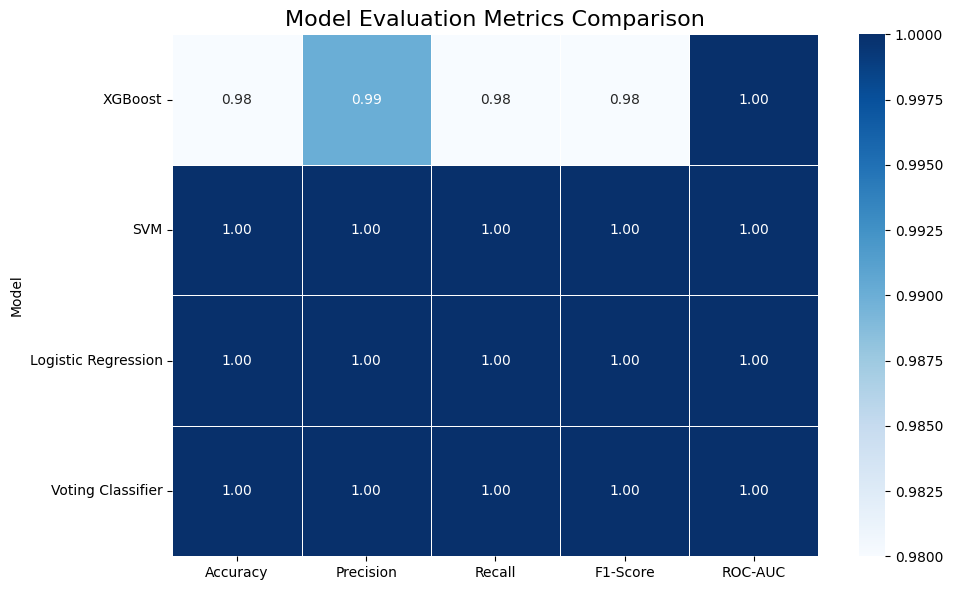

In [18]:
# metrics values for each model
metrics_data = {
    'Model': ['XGBoost', 'SVM', 'Logistic Regression', 'Voting Classifier'],
    'Accuracy': [0.98, 1.00, 1.00, 1.00],
    'Precision': [0.99, 1.00, 1.00, 1.00],
    'Recall': [0.98, 1.00, 1.00, 1.00],
    'F1-Score': [0.98, 1.00, 1.00, 1.00],
    'ROC-AUC': [1.00, 1.00, 1.00, 1.00]
}

# Converting the dictionary to a DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics_data)

# Setting 'Model' column as the index for better readability
metrics_df.set_index('Model', inplace=True)

# Displaying the metrics table
print(metrics_df)

# Plotting the evaluation metrics using a heatmap with blue shades
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Model Evaluation Metrics Comparison', fontsize=16)
plt.tight_layout()
plt.show()


#### Log Training Times for Each Model

Training Times:
SVM: 0.7491 seconds
Logistic Regression: 4.4159 seconds
XGBoost: 2.7195 seconds
Voting Classifier: 5.3031 seconds


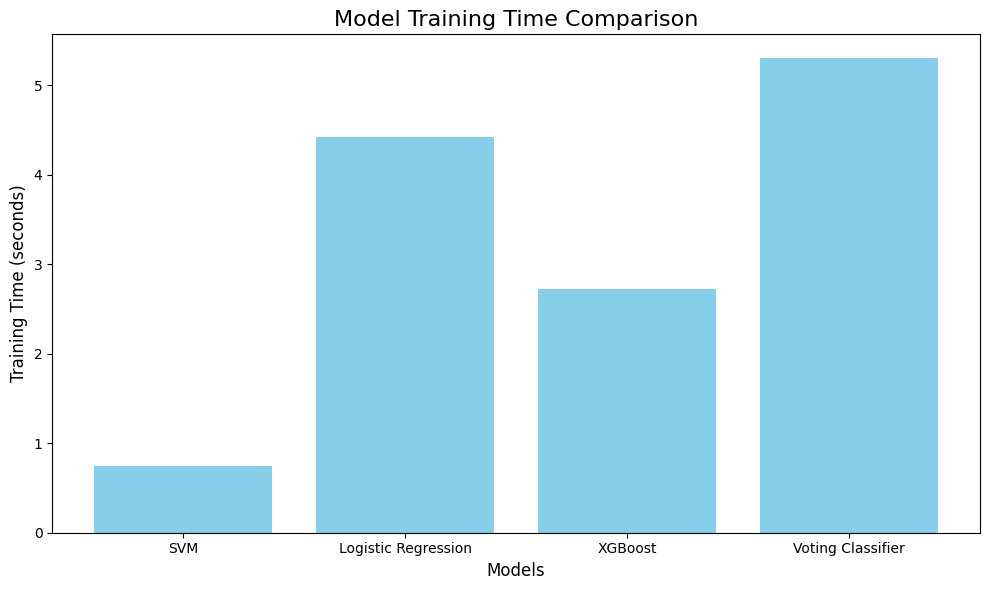

In [19]:
# Logging training time for each model
training_times = {}

# SVM Model
start_time = time.time()
best_svm_model.fit(X_train_pca, y_train)  # Use PCA-transformed data for SVM
training_times['SVM'] = time.time() - start_time

# Logistic Regression Model
start_time = time.time()
best_logistic_model.fit(X_train, y_train)
training_times['Logistic Regression'] = time.time() - start_time

# XGBoost Model
start_time = time.time()
best_xgb_model.fit(X_train, y_train)
training_times['XGBoost'] = time.time() - start_time

# Voting Classifier
start_time = time.time()
voting_clf.fit(X_train, y_train)
training_times['Voting Classifier'] = time.time() - start_time

# Printing training times for each model
print("Training Times:")
for model, time_taken in training_times.items():
    print(f"{model}: {time_taken:.4f} seconds")

# Plotting the training times
plt.figure(figsize=(10, 6))
plt.bar(training_times.keys(), training_times.values(), color='skyblue')

# Adding labels and title
plt.title('Model Training Time Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


These diagram summarizes the results, highlighting the strengths of each model. While the SVM and Voting Classifier had the best overall performance, XGBoost showed great efficiency in terms of training time. The Logistic Regression model, while slower, was still reliable and achieved perfect scores. This diagram gives a quick overview of how each model stacks up against each other.